In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data set

In [2]:
def read_file(file_path,rows=100000):
    data_dict = {'cust_id':[], 'movie_id':[],'rating':[],'date':[]}
    f= open(file_path,"r")
    count = 0
    for line in f:
        count+=1
        if count>rows:
            break
        if ':' in line:
            movie_id = line[:-2]
            movie_id = int(movie_id)
        else:
            line = line.rstrip("\n") #remove new lines
            tmp = line.split(",")
            data_dict['cust_id'].append(tmp[0]) #customer id
            data_dict['movie_id'].append(movie_id) 
            data_dict['rating'].append(tmp[1]) #rating
            data_dict['date'].append(tmp[2]) #date
    f.close()
    
    df = pd.DataFrame(data_dict)
    df['cust_id'] = df['cust_id'].astype('int')
    df['rating'] = df['rating'].astype('float')
    return df


        

In [3]:
df1 = read_file("/Users/tahsin/Documents/kaggle/netflix/combined_data_1.txt")
df2 = read_file("/Users/tahsin/Documents/kaggle/netflix/combined_data_2.txt")
df3 = read_file("/Users/tahsin/Documents/kaggle/netflix/combined_data_3.txt")
df4 = read_file("/Users/tahsin/Documents/kaggle/netflix/combined_data_4.txt")

In [4]:
df1.head(3)

,cust_id,movie_id,rating,date
0,1488844,1,3.0,2005-09-06
1,822109,1,5.0,2005-05-13
2,885013,1,4.0,2005-10-19


In [5]:
df1.dtypes

cust_id       int64
movie_id      int64
rating      float64
date         object
dtype: object

In [6]:
df = df1.copy()
df = df.append(df2)
df = df.append(df3)
df = df.append(df4)

df.index = np.arange(0,len(df))
df.head(5)

,cust_id,movie_id,rating,date
0,1488844,1,3.0,2005-09-06
1,822109,1,5.0,2005-05-13
2,885013,1,4.0,2005-10-19
3,30878,1,4.0,2005-12-26
4,823519,1,3.0,2004-05-03


In [7]:
df_title = pd.read_csv("/Users/tahsin/Documents/kaggle/netflix/movie_titles.csv",
                       encoding = "ISO-8859-1",
                       header = None,
                       names=['movie_id','year','name'])
df_title.head(5)

,movie_id,year,name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


# EAD

In [8]:
print("Any Null values?: ", sum(df.isnull().any()))
print("Total Users:", len(np.unique(df["cust_id"])))
print("Total Movies:", len(np.unique(df["movie_id"])))

Any Null values?:  0
Total Users: 172421
Total Movies: 101


In [9]:
df.describe()['rating']

count    399899.000000
mean          3.549514
std           1.080856
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

/Users/tahsin/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


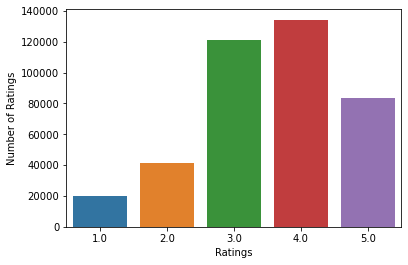

In [10]:
sns.countplot(df["rating"])
plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.show()

# Train model

In [11]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection.validation import cross_validate

reader = Reader()

data = Dataset.load_from_df(df[['cust_id','movie_id','rating']],reader)

svd = SVD()



In [13]:
# 5 flod cross validation
cross_validate(svd, data, measures=['RMSE','MSE'],cv = 5, verbose = True)


Evaluating RMSE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0188  1.0162  1.0166  1.0155  1.0123  1.0159  0.0021  
MSE (testset)     1.0379  1.0327  1.0334  1.0313  1.0249  1.0320  0.0042  
Fit time          15.58   16.21   15.59   15.24   15.24   15.57   0.36    
Test time         0.62    0.67    0.46    0.63    0.44    0.56    0.10    


{'test_rmse': array([1.01876531, 1.01622999, 1.0165784 , 1.01550826, 1.01234914]),
 'test_mse': array([1.03788276, 1.03272339, 1.03343164, 1.03125702, 1.02485079]),
 'fit_time': (15.576896905899048,
  16.214684009552002,
  15.585033893585205,
  15.24022912979126,
  15.239521980285645),
 'test_time': (0.624558687210083,
  0.6672379970550537,
  0.4554939270019531,
  0.6313118934631348,
  0.43823695182800293)}

In [14]:
train_data = data.build_full_trainset()
svd.fit(train_data)

# Prediction

In [15]:
titles = df_title.copy()

titles['Estimate'] = titles['movie_id'].apply(lambda x:svd.predict(785314, x).est)
titles = titles.sort_values(by=['Estimate'], ascending = False)
titles.head(5)

,movie_id,year,name,Estimate
9235,9236,1998.0,South Park: Season 2,4.154385
12,13,2003.0,Lord of the Rings: The Return of the King: Ext...,4.036313
13374,13375,1963.0,Andy Griffith Show: Classic Favorites,3.769478
13379,13380,1949.0,Stray Dog,3.640061
24,25,1997.0,Inspector Morse 31: Death Is Now My Neighbour,3.566439


In [16]:
df_785314 = df[(df['cust_id'] == 785314) & (df['rating'] == 5)]
df_785314 = df_785314.set_index('movie_id')
df_785314 = df_785314.join(titles)['name']
df_785314.head()

movie_id
9236                       The Witches
13378    Kim Possible: A Sitch in Time
Name: name, dtype: object

In [31]:
# with train and test set
from surprise.model_selection import train_test_split
from surprise import accuracy
trainset, testset = train_test_split(data, test_size=0.2)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.0136


1.013635631279604